# Preprocessing raw data

In [3]:
# Import some packages
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib
import warnings

dtype = tf.float32

In [4]:
## OLD

# LOAD ALL THE DATA FROM THE ORIGINAL FILES

# data = pd.read_csv("M1Data/M1_combined_counts.tab", sep='\t')
# counts = data.values[:,1:].transpose().astype(float)
# genes = data.values[:,0]
# cells = np.array(data.columns[1:])

# ## Attach Shipment 9 (different assembly)

# data = pd.read_csv("M1Data/shp_9_M1_counts.tab", sep='\t')
# counts2 = data.values[:,1:].transpose().astype(float)
# genes2 = data.values[:,0]
# cells2 = np.array(data.columns[1:])

# data = pd.read_csv("M1Data/shp_10_counts.txt", sep='\t')
# data1 = pd.read_csv('M1Data/patch_seq_11_counts.txt', sep='\t')
# counts3 = data.values[:,1:].transpose().astype(float)
# counts4 = data1.values[:,1:].transpose().astype(float)
# genes3 = data.values[:,0]
# genes4 = data1.values[:,0]
# cells3 = np.array(data.columns[1:])
# cells4 = np.array(data1.columns[1:])
# cells3 = np.array([c.lower() for c in cells3])
# cells4 = np.array([c.lower() for c in cells4])
# assert(np.all(genes2==genes3))
# assert(np.all(genes2==genes4))
# counts2 = np.concatenate((counts2, counts3, counts4), axis=0)
# cells2 = np.concatenate((cells2, cells3, cells4), axis=0)

# counts2_resorted = np.zeros((counts2.shape[0], counts.shape[1]))
# genes_map = np.array([[i, np.where(genes2==g)[0][0]] for i,g in enumerate(genes) if g in genes2])
# counts2_resorted[:, genes_map[:,0]] = counts2[:, genes_map[:,1]]

# counts = np.concatenate((counts, counts2_resorted), axis=0)
# cells = np.concatenate((cells, cells2))

# ## End attach

# goodReseq = [('reseq' in c) and (int(c[:6])>=201809) and (int(c[:6])<=201811) for c in cells]
# badReseq = np.isin(['_'.join(c.split('_')[:3]) for c in cells], 
#                    ['_'.join(c.split('_')[:3]) for c in cells[goodReseq]]) & ~np.array(goodReseq)
# counts = counts[~badReseq]
# cells[goodReseq] = [c[:-12] for c in cells[goodReseq]]
# cells = cells[~badReseq]

# selection = [i for i,c in enumerate(cells) if 'BLANK' not in c and 'Blank' not in c 
#              and 'blank' not in c and 'resequenced' not in c and 'lowyield' not in c
#              and 'undetermined' not in c]
# counts = counts[selection,:]
# cells  = cells[selection]


# rpkm = pd.DataFrame(counts, cells, columns = genes)
# rpkm = rpkm.T

In [5]:
## NEW

# Use this if you have the full raw data, simply use the next 
rpkm = pd.read_csv('M1Data/final_patch_seq_allcells_exon_allreads.txt', sep='\t')
rpkm = rpkm.set_index('gene')
new_keys = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) \
            for g in rpkm.keys().tolist()] # Changing column names
rpkm.columns = new_keys

In [6]:
print('all cells with transcriptimic data: ', rpkm.shape)
M1_ephys = pd.read_csv('M1Data/Cell_Features_M1.csv')
M1_ephys = M1_ephys.drop(['Unnamed: 0'], axis=1)
ephysProperties = ['AP amp FF', 'AP amp', 'AP amp adapt', 'AP amp average adapt', 'AP amp CV', 'AP thresh', \
                   'AP width', 'ADP', 'AHP', 'Burstiness', 'ISI FF',
                    'ISI adapt', 'ISI average adapt', 'ISI CV', 'R_i', 'Latency', 'Max number of APs', 'Tau',
                   'Rebound',  'Rebound number of APs', 'Vm', 'Rheobase', 'Sag area', 'Sag', 'Sag time', \
                   'SFA', 'UDR', 'Wildness']

# Cells for which ephys properties are available:
cells_w_ephys = ['{}{}{}{}{}'.format(g.split('/')[-1].split(' ')[2], g.split('/')[-1].split(' ')[0], \
                                     g.split('/')[-1].split(' ')[1], 'sample', \
                                     g.split('/')[-1].split(' ')[-1].split('.')[0]) \
                  for g in M1_ephys['name sample'].tolist()]

M1_ephys['Name sample'] = cells_w_ephys
M1_ephys = M1_ephys.drop(['name sample'], axis = 1)
M1_ephys = M1_ephys.rename(columns = {'Name sample': 'name sample'})
M1_ephys = M1_ephys.set_index('name sample')

M1_ephys.columns = ephysProperties

print('cells with ephys properties: ', len(cells_w_ephys))

# Find the cells first for which ephys properties are available but no genetic properties.
# Delete these from cells_w_ephys
no_gene = []
for cell in cells_w_ephys:
    if cell not in rpkm.columns:
        print('cell with ephys but no genetic properties: ', cell)
        no_gene.append(cell)
for cell in no_gene:
    cells_w_ephys.remove(cell)

no_ephys = []
for cell in rpkm.keys():
    if cell not in M1_ephys.index:
        print('cell with genetic but no ephys properties: ', cell)
        no_ephys.append(cell)
# Scrap the ephys cells for which no genetic info exists
M1_ephys = M1_ephys.loc[cells_w_ephys]
print('cells with ephys after elimination of cells with no rna-seq data: ', len(cells_w_ephys))


# Drop cells where the ephys and rna don't match
M1_ephys = M1_ephys.drop(['20180315sample6'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20180321sample4'], axis = 0) # MC firing and morphology but excitatory RNA
M1_ephys = M1_ephys.drop(['20181116sample10'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20190325sample2'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20190611sample1'], axis = 0) # mismatch (L1 firing and morphology but excitatory RNA)
M1_ephys = M1_ephys.drop(['20190611sample11'], axis = 0) # mismatch (L1 firing and morphology but excitatory RNA)
M1_ephys = M1_ephys.drop(['20190704sample2'], axis = 0) # outside of M1



print("cells with ephys properties after exclusion of certain cells\n(Nan ephys property or ephys and rna don't match): ", \
              len(M1_ephys.index))

# Feature transformations
# According to the stripplot, certain transformations of some properties are in place
M1_ephys = M1_ephys.drop('SFA', axis = 1)
M1_ephys['ISI adapt'] = np.log(M1_ephys['ISI adapt'])
M1_ephys['ISI average adapt'] = sigmoid(M1_ephys['ISI average adapt'], offset = 1, steepness = 2)
M1_ephys['ISI FF'] = np.log(M1_ephys['ISI FF'])
M1_ephys['ISI CV'] = np.log(M1_ephys['ISI CV'])
M1_ephys['AP amp CV'] = np.log(M1_ephys['AP amp CV'])
M1_ephys['AP amp FF'] = np.log(M1_ephys['AP amp FF'])
M1_ephys['AP amp average adapt'] = sigmoid(M1_ephys['AP amp average adapt'], offset = 1, steepness = 50)
M1_ephys['Latency'] = np.log(M1_ephys['Latency'])

select = True # Set to True if you'd like to drop certain features for certain reasons
if select: #!!!!! Make sure that SFA is already dropped
    M1_ephys = M1_ephys.drop('ADP', axis=1) # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('Sag time', axis=1) # sag should be meaningfull enough (we don't want too many corr.)
                                                           # it also has too many 0's
    M1_ephys = M1_ephys.drop('Sag area', axis=1) # sag should be meaningfull enough (we don't want too many corr.)
                                                           # it also has too many 0's
    M1_ephys = M1_ephys.drop('AP amp FF', axis=1) # the log is heavily correlated with log(AP_cv)
    M1_ephys = M1_ephys.drop('ISI FF', axis=1) # the log is heavily correlated with log(cv)
    M1_ephys = M1_ephys.drop('Wildness', axis=1) # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('Rebound number of APs', axis=1) # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('ISI average adapt', axis=1) # too skewed of a feature
    M1_ephys = M1_ephys.drop('AP amp average adapt', axis=1) # too skewed of a feature
    M1_ephys = M1_ephys.drop('Burstiness', axis=1) # too many cells have zero for this feature
    M1_ephys = M1_ephys.drop('Latency', axis=1) # too many outliers

ephysProperties = M1_ephys.keys()

M1_ephys = M1_ephys.dropna() # We drop Nans here because SFA causes too many Nans and we don't want to lose too much data

# Now delete all the cells with genetic data for which no ephys properties exist
rpkm = rpkm[list(M1_ephys.index)]

# Remember rpkm has the cells for which there's ephys + transcriptomic data and for which you could geneSelection
# in the future too for a subset of cells!
print('All cells with ephys + transcriptomic data (after exclusion of Nan ephys property data: ', rpkm.shape)
M1_ephys = M1_ephys.reindex(rpkm.columns)

# Now specify for all the cells left what the cell type is (according to transcriptomic mappings)
prop = pd.read_csv('M1Data/mini-atlas-meta-data.csv', sep = '\t')
prop = prop.rename(columns = {'Sample': 'sample_id', 'Targeted layer': 'Layer'})
prop = prop[['Cell', 'RNA type', 'sample_id', 'Layer', 'Cre', 'RNA type top-3']]
#sample_name = ['{}{}{}'.format(g.split(' ')[0], 'sample', g.split(' ')[-1]) \
#               for g in (prop['Cell'].map(str.strip) + prop['sample_id'].map(str.strip)).tolist()]
sample_name = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) for g in prop['Cell']]
prop['sample name'] = sample_name
prop = prop.set_index('sample name')

prop = prop.reindex(M1_ephys.index) # There could be more cells with ephys than manually labelled
                                    # They will receive the Nan property
prop = prop.fillna('')
#M1_Allen_Mapping = np.array([g.split(',')[0].split('(')[0][:-1] if ',' in g else g.split('(')[0][:-1] \
#                             for g in prop['RNA type top-3']])
M1_Allen_Mapping = prop['RNA type']
M1_Allen_Mapping[np.where(M1_Allen_Mapping == '')[0]] = 'low quality'
number_labels = {c: i for i, c in enumerate(np.unique(M1_Allen_Mapping))}
cellTypes = np.array([number_labels[cell_type] for cell_type in M1_Allen_Mapping])

# Double-check
print('RPKM shape:', rpkm.shape)
print('ephys shape:', M1_ephys.shape)
print('cellTypes shape:', cellTypes.shape)
#print('cellClasses shape: ', cell_classes.shape)
print('ephys properties:', ', '.join(ephysProperties))

all cells with transcriptimic data:  (42184, 1320)
cells with ephys properties:  1319
cell with genetic but no ephys properties:  20190211sample10
cells with ephys after elimination of cells with no rna-seq data:  1319
cells with ephys properties after exclusion of certain cells
(Nan ephys property or ephys and rna don't match):  1312
All cells with ephys + transcriptomic data (after exclusion of Nan ephys property data:  (42184, 1304)
RPKM shape: (42184, 1304)
ephys shape: (1304, 16)
cellTypes shape: (1304,)
ephys properties: AP amp, AP amp adapt, AP amp CV, AP thresh, AP width, AHP, ISI adapt, ISI CV, R_i, Max number of APs, Tau, Rebound, Vm, Rheobase, Sag, UDR


In [7]:
# We are not interested in low quality rna cells
M1_ephys = M1_ephys.loc[cellTypes!=77]
rpkm = rpkm.T.loc[cellTypes!=77, :].T
print('RPKM shape:', rpkm.shape)
print('ephys shape:', M1_ephys.shape)

Chosen offset: 7.56


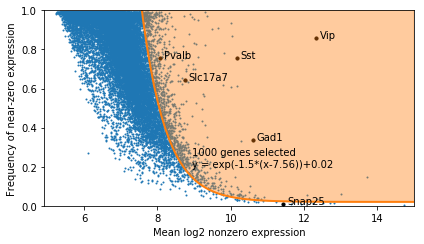

In [10]:
# We choose n most variable genes based on an heuristic appoach employed by Dmitry et al. in "The art of using t-sne
# for single-cell transcriptomics"
amount_of_genes = 1000
markerGenes = ['Snap25', 'Gad1', 'Slc17a7', 'Pvalb', 'Sst', 'Vip']
selectedGenes = sparseRRR.geneSelection(rpkm.T.values.astype(np.float), n=amount_of_genes, threshold=30, \
                                          markers=markerGenes, genes=np.array(list(rpkm.index)))
rpkm = rpkm.loc[selectedGenes]

In [11]:
rpkm.to_csv('M1Data/gene_counts.csv')
M1_ephys.to_csv('M1Data/ephys_values.csv')